<a href="https://colab.research.google.com/github/Angelvj/TFG/blob/main/code/jupyter/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports
import numpy as np
import tensorflow as tf
import keras as k
import sklearn
import nibabel as nib
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, MaxPool3D, GlobalAveragePooling3D
from keras.utils import to_categorical
import matplotlib.pyplot as plt

import time
import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import svm
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import LinearSVC
from sklearn import decomposition
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load data and impute NaN values

In [3]:
# Load data
COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_PATH = '/content/drive/My Drive/Machine learning/data'

else: 
  DATA_PATH = '../../data'

def load_image(filename):    
    """
    
    Parameters
    ----------
    filename : str
        relative path to de image

    Returns
    -------
    img : numpy ndarray
        array containing the image
        
    """
    img = nib.load(filename)
    img = np.asarray(img.dataobj)
    img = np.expand_dims(img, axis=3)
    return img


def load_images_from_dir(dirname):
    """
    
    Parameters
    ----------
    dirname : str
        name of the directory containing images.

    Returns
    -------
    imgs : numpy ndarray
        array containing all of the images in the folder.

    """
    imgs = []

    for filename in tqdm(glob.glob(dirname + '/*.nii')):
        imgs.append(load_image(filename))
        
    imgs = np.stack(imgs) # All images over the new first dimension
    return imgs

def load_data(dirs_dict, categorical = False):
    """
    
    Parameters
    ----------
    dirs_dict : dictionary
        dictionary containing data folders name, and the label for the images
        on each forlder.

    Returns
    -------
    x : numpy ndarray
        array containing the images.
    y : numpy ndarray
        array containig the label of each image.

    """
    first = True
    for key, value in dirs_dict.items():
        if first:
            X = load_images_from_dir(value)
            # ¿necesario float32 o puedo usar uint8?
            y = np.full((X.shape[0]), key, dtype=np.float32)
            first = False
        else:
            X_current = load_images_from_dir(value)
            X = np.concatenate((X, X_current), axis=0)
            y = np.concatenate((y, np.full((X_current.shape[0]), key, dtype=np.float32)), axis=0)
            
    if categorical:
        y = k.utils.to_categorical(y)
    
    return X, y

def impute_nan_values(imgs, inplace=True):
    # Replace nan values with 0
    return np.nan_to_num(imgs, copy = not inplace)

# Load PET images with labels
print('\n --- Loading PET data --- \n')
time.sleep(0.5)
X, y = load_data({0: DATA_PATH + "/ppNOR/PET", 
                  1: DATA_PATH + "/ppAD/PET",
                  2: DATA_PATH + "/ppMCI/PET"})

# Separate into training and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 1)

impute_nan_values(X_train)
impute_nan_values(X_test)

print('\n --- PET data loaded --- \n')

Mounted at /content/drive

 --- Loading PET data --- 



100%|██████████| 111/111 [00:52<00:00,  2.12it/s]



 --- PET data loaded --- 



# Preprocessing data

In [4]:
def max_intensity_normalization(X, percentage, inplace=True):

    if not inplace:
        X = X.copy()

    volume_shape = X[0].shape
    n_max_values = int((volume_shape[0]*volume_shape[1]*volume_shape[2]*percentage)/100)

    for i in range(len(X)):
        n_max_idx = np.unravel_index((X[i]).argsort(axis=None)[-n_max_values:], X[i].shape)
        mean = np.mean(X[i][n_max_idx])
        X[i] /= mean

    if not inplace:
        return X

X_train_n = max_intensity_normalization(X_train, 1, inplace=False)

In [5]:
# # Test SVM classifier first
# x_tr, x_val, y_tr, y_val = train_test_split(X_train_n, y_train, test_size = 0.2, stratify = y_train)

# x_tr_1D = np.empty((x_tr.shape[0], x_tr.shape[1]*x_tr.shape[2]*x_tr.shape[3]))

# # Convert each image to a single dimension ndarray
# for i in range(len(x_tr)):
#     x_tr_1D[i] = x_tr[i].flatten()

# x_val_1D = np.empty((x_val.shape[0], x_val.shape[1]*x_val.shape[2]*x_val.shape[3]))
# for i in range(len(y_val)):
#     x_val_1D[i] = x_val[i].flatten()

# # clf = svm.SVC(kernel='linear', C=0.8)
# # clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=0.05)) # 0.48 en 5 tiradas
# # clf.fit(x_tr_1D, y_tr)

# print(clf.score(x_tr_1D, y_tr))
# print(clf.score(x_val_1D, y_val))

In [6]:
# Loading MRI images, its a bit different process because they are separated into 
# gray and white matter

# def load_mri_data(dict_dirs, categorical = False):
#     pass

# # Pruebo a cargar una imagen cualquiera
# image = load_image(DATA_PATH + "/ppNOR/MRI/greyMatter/m0wrp1ADNI_005_S_0223_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070809183352346_S19963_I66520.nii")

# print(type(image))
# print(image.shape)

In [7]:
def learning_curve(hist):
    history_dict = hist.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.show()

In [8]:
def cross_validate(model, x_train, y_train, num_folds, opt, batch_size, epochs, verbose=0, show_history=False):

    # Creamos un objeto kfold, especificando el número de segmentos que queremos utilizar,
    # además utilizamos shuffle true, para que los num_folds conjuntos disjuntos se seleccionen
    # de forma aleatoria, evitando de esta forma problemas que podría haber si los datos
    # estuvieran ordenados siguiendo una cierta distribución

    skfold = StratifiedKFold(n_splits = num_folds, shuffle=True)

    model.compile(loss = k.losses.categorical_crossentropy, optimizer=opt,
                metrics = ['accuracy'])

    initial_weights = model.get_weights()

    acc_per_fold = []
    loss_per_fold = []

    fold_no = 1

    for kfold_train, kfold_test in skfold.split(x_train, y_train):

        # En cada fold, comenzamos con los pesos iniciales. Tratamos de que las 5
        # folds sean lo más independientes posible.
        model.set_weights(initial_weights)

        print('------------------------------------------------------------------------')
        print(f'Entrenando para el fold {fold_no} ...')


        print('Clases en train: ', np.sum(k.utils.to_categorical(y_train[kfold_train]), axis=0))
        print('Clases en validación: ', np.sum(k.utils.to_categorical(y_train[kfold_test]), axis=0))

        history = model.fit(x_train[kfold_train], 
                            k.utils.to_categorical(y_train[kfold_train]), 
                            batch_size= batch_size,
                            epochs=epochs, verbose = verbose, 
                            validation_data = (x_train[kfold_test], k.utils.to_categorical(y_train[kfold_test]))
                            )

        if show_history:
            # Mostramos la evolución en cada fold
            learning_curve(history)

        # Número de épocas que se han utilizado
        print('Numero de épocas realizadas: ', len(history.history['loss']))

        # Calculamos la bondad del modelo para el fold reservado para testing
        scores = model.evaluate(x_train[kfold_test], k.utils.to_categorical(y_train[kfold_test]), verbose=0)

        # Vamos guardando el accuracy y pérdida para cada fold
        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        print(f'Resultado para el fold {fold_no}: {model.metrics_names[0]} de {scores[0]}; {model.metrics_names[1]} de {scores[1]*100}%')

        fold_no += 1

    # ==  Mostramos los valores medios == 
    print('------------------------------------------------------------------------')
    print('Resultados por cada fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Media de los resultados para todos los folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)}')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

# Define models


 --------------- MODELO 4 ------------------

------------------------------------------------------------------------
Entrenando para el fold 1 ...
Clases en train:  [48. 51. 80.]
Clases en validación:  [6. 5. 9.]


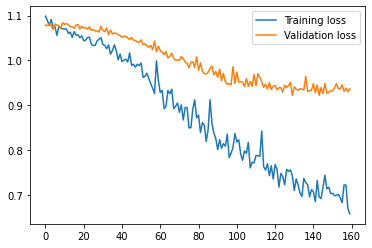

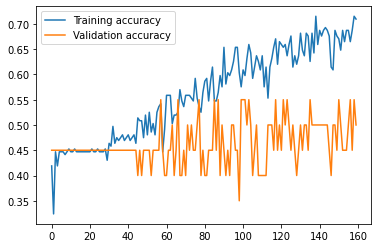

Numero de épocas realizadas:  160
Resultado para el fold 1: loss de 0.9369610548019409; accuracy de 50.0%
------------------------------------------------------------------------
Entrenando para el fold 2 ...
Clases en train:  [48. 51. 80.]
Clases en validación:  [6. 5. 9.]


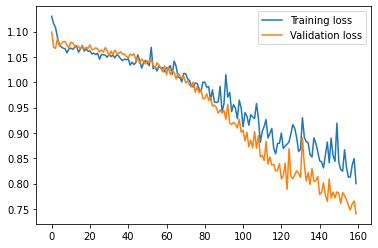

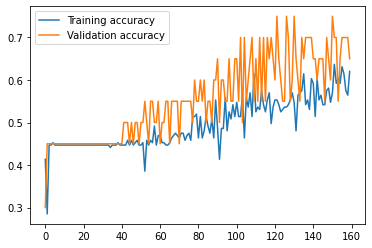

Numero de épocas realizadas:  160
Resultado para el fold 2: loss de 0.7399462461471558; accuracy de 64.99999761581421%
------------------------------------------------------------------------
Entrenando para el fold 3 ...
Clases en train:  [48. 51. 80.]
Clases en validación:  [6. 5. 9.]


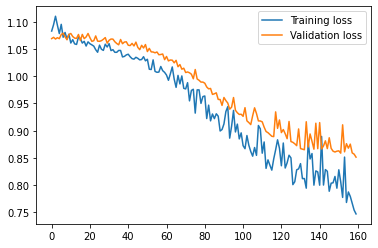

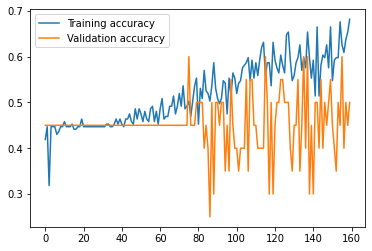

Numero de épocas realizadas:  160
Resultado para el fold 3: loss de 0.8513250350952148; accuracy de 50.0%
------------------------------------------------------------------------
Entrenando para el fold 4 ...
Clases en train:  [49. 50. 80.]
Clases en validación:  [5. 6. 9.]


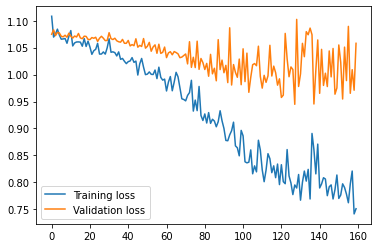

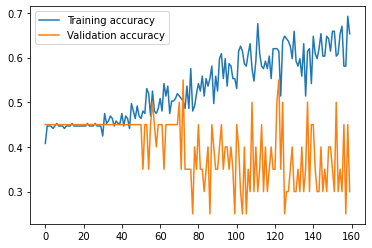

Numero de épocas realizadas:  160
Resultado para el fold 4: loss de 1.0580500364303589; accuracy de 30.000001192092896%
------------------------------------------------------------------------
Entrenando para el fold 5 ...
Clases en train:  [49. 50. 80.]
Clases en validación:  [5. 6. 9.]


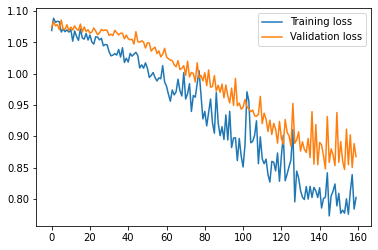

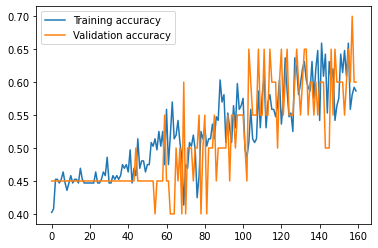

Numero de épocas realizadas:  160
Resultado para el fold 5: loss de 0.8676042556762695; accuracy de 60.00000238418579%
------------------------------------------------------------------------
Entrenando para el fold 6 ...
Clases en train:  [49. 50. 80.]
Clases en validación:  [5. 6. 9.]


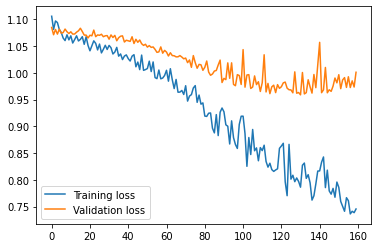

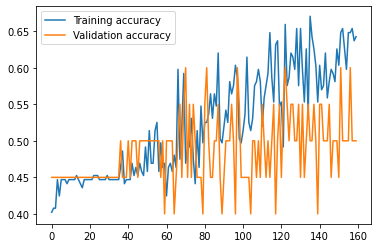

Numero de épocas realizadas:  160
Resultado para el fold 6: loss de 1.0010013580322266; accuracy de 50.0%
------------------------------------------------------------------------
Entrenando para el fold 7 ...
Clases en train:  [49. 50. 80.]
Clases en validación:  [5. 6. 9.]


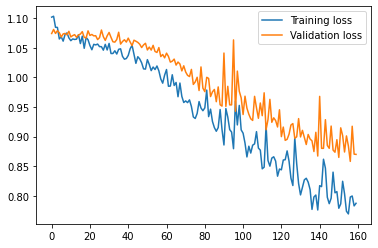

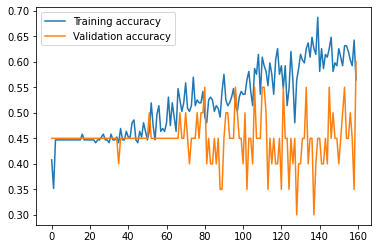

Numero de épocas realizadas:  160
Resultado para el fold 7: loss de 0.870011031627655; accuracy de 60.00000238418579%
------------------------------------------------------------------------
Entrenando para el fold 8 ...
Clases en train:  [49. 50. 80.]
Clases en validación:  [5. 6. 9.]


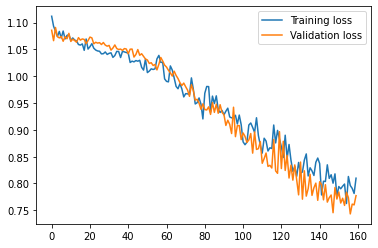

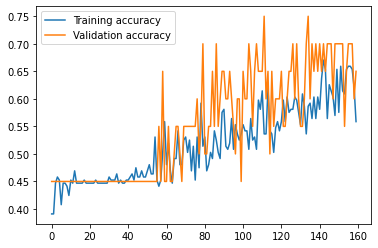

Numero de épocas realizadas:  160
Resultado para el fold 8: loss de 0.7773730158805847; accuracy de 64.99999761581421%
------------------------------------------------------------------------
Entrenando para el fold 9 ...
Clases en train:  [49. 50. 80.]
Clases en validación:  [5. 6. 9.]


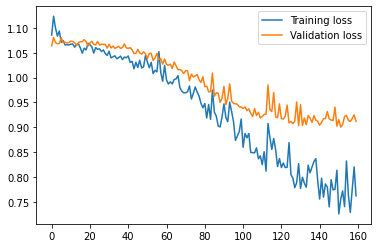

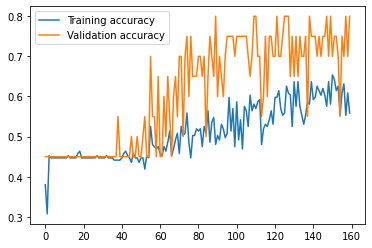

Numero de épocas realizadas:  160
Resultado para el fold 9: loss de 0.912032961845398; accuracy de 80.0000011920929%
------------------------------------------------------------------------
Entrenando para el fold 10 ...
Clases en train:  [48. 51. 81.]
Clases en validación:  [6. 5. 8.]


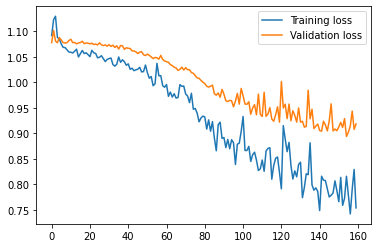

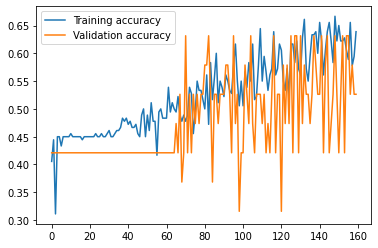

Numero de épocas realizadas:  160
Resultado para el fold 10: loss de 0.9183729290962219; accuracy de 52.63158082962036%
------------------------------------------------------------------------
Resultados por cada fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9369610548019409 - Accuracy: 0.5%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.7399462461471558 - Accuracy: 0.6499999761581421%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8513250350952148 - Accuracy: 0.5%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0580500364303589 - Accuracy: 0.30000001192092896%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8676042556762695 - Accuracy: 0.6000000238418579%
------------------------------------------------------------------------
> Fold 6 - Loss: 1.00100135803222

In [14]:
# CNN MODELS

# Model configuration
sample_shape = (79,95,68,1)
no_classes = 3

# First very basic model:
'''
 - A pesar de ser muy pequeño sufre de overfitting (bajo loss en training pero
 alto validación cruzada) 

- Podemos crear otro modelo a continuación aplicando alguna técnica de regula-
rización, por ejemplo dropout

'''
def get_basic_model(width=79, height=95, depth=68):

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="baseline_3Dcnn")
    return model


def get_first_model(width=79, height=95, depth=68):

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)
    x = Dropout(0.3)(x)

    model = k.Model(inputs, outputs, name="baseline_3Dcnn")
    return model


def get_second_model(width=79, height=95, depth=68):

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)
    x = Dropout(0.5)(x)

    model = k.Model(inputs, outputs, name="baseline_3Dcnn")
    return model


def get_third_model(width=79, height=95, depth=68):

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)
    x = Dropout(0.5)(x)

    model = k.Model(inputs, outputs, name="baseline_3Dcnn")
    return model


def get_fourth_model(width=79, height=95, depth=68):

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    x = Dropout(0.1)(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = Dropout(0.1)(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = Dropout(0.1)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)
    x = Dropout(0.1)(x)

    outputs = Dense(units=3, activation="softmax")(x)
    x = Dropout(0.5)(x)

    model = k.Model(inputs, outputs, name="baseline_3Dcnn")
    return model


def get_fith_model(width=79, height=95, depth=68):

    # Where do I put the dropout layers? https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)
    x = Dropout(0.1)(x)

    outputs = Dense(units=3, activation="softmax")(x)
    x = Dropout(0.5)(x)

    model = k.Model(inputs, outputs, name="baseline_3Dcnn")
    return model


# Second model: little deeper
# def get_model(width=79, height=95, depth=68):
#     """Build a 3D convolutional neural network model."""

#     inputs = k.Input((width, height, depth, 1))

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
#     x = MaxPool3D(pool_size=2)(x)
#     x = BatchNormalization()(x)

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = MaxPool3D(pool_size=2)(x)
#     x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = MaxPool3D(pool_size=2)(x)
#     x = BatchNormalization()(x)

#     x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = MaxPool3D(pool_size=2)(x)
#     x = BatchNormalization()(x)

#     x = GlobalAveragePooling3D()(x)
#     x = Dense(units=512, activation="relu")(x)
#     x = Dropout(0.3)(x)

#     outputs = Dense(units=3, activation="softmax")(x)

#     # Define the model.
#     model = k.Model(inputs, outputs, name="3dcnn")
#     return model


def get_model(model_no):
    """
    Return the selected model

    """
    if model_no == 0:
        return get_basic_model()
    elif model_no == 1:
        return get_first_model()
    elif model_no == 2:
        return get_second_model()
    elif model_no == 3:
        return get_third_model()
    elif model_no == 4:
        return get_fourth_model()
    elif model_no == 5:
        return get_fith_model()


# Build model.
model = get_model(0)
# model.summary()

# Compile the model 
# model.compile(loss='categorical_crossentropy', optimizer=k.optimizers.Adam(), metrics=['accuracy'])

# Fit model to data
# Batch size of 32 as a standard starting point: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ ?

# Pruebas relacionadas con el optimizador hechas sobre el modelo base
# print('\n --------------- PRUEBA 1 ------------------\n')
# cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.00001), 16, 30, 
#                verbose = 0, show_history = True)

# Pruebas de distintos modelos
# print('\n --------------- MODELO 1 ------------------\n')
# model = get_model(1)
# cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.00001), 16, 30, 
#                verbose = 0, show_history = True)

# print('\n --------------- MODELO 2 ------------------\n')
# model = get_model(2)
# cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.00001), 16, 40, 
#                verbose = 0, show_history = True)

# print('\n --------------- MODELO 3 ------------------\n')
# model = get_model(3)
# cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.00001), 16, 50, 
#                verbose = 0, show_history = True)

print('\n --------------- MODELO 4 ------------------\n')
model = get_model(4)
cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.00001), 16, 160, 
               verbose = 0, show_history = True)

# print('\n --------------- PRUEBA 8 ------------------\n')
# model = get_model(5)
# cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.00001), 16, 30, 
#                verbose = 0, show_history = True)